# Transfer Learning in NLP : semi-frozen embeddings



## Introduction & Problem Statement

The idea behind *"transfer learning"* is to take a state of the art model pre-trained on a massive dataset and then *fine-tuning* the model on a new related task where the training data is insufficient to train an analogous model. Transfer learning is gaining more and more traction in the NLP world with models such as [BERT](https://arxiv.org/abs/1810.04805), [Elmo](https://arxiv.org/abs/1802.05365) and [ULMFit](https://arxiv.org/abs/1801.06146) showing the enormous potential. 

To be fair, transfer learning has been around for quite some time but in a more relaxed setting: the usage of *pretrained word embeddings*.

Unfortunately, there is a huge problem - particularly when transferring knowledge from one domain to another - the problem of **vocabulary mismatch**. Very often, the target domain contains words which are quite specific and important, but they are missing from the original domain. It is vital to incorporate these words in the model, but their absence from the pretrained embeddings vocabulary makes it problematic.
There are three obvious options for modeling them:
1. **Discard** the pretrained embeddings, start from scratch with a random init.
2. Set the unknown words to the mean of the pretrained embeddings and **keep them frozen**
3. Set the unknown words to the mean of the pretrained embeddings and **unfreeze the entire layer**

All of these have their drawbacks:   
Option 1. discards any notion of transfer learning.   
Option 2. treats all unknown words the same and keeps them frozen, thus failing to model them effectively.        
In my experiments, Option 3. would eventually lose all prior knowledge and overfit on the training set.

Thus, I propose a compromise: **Semi-Frozen Embeddings**. The semi-frozen embeddings module would split the embeddings into two groups: a frozen group and a trainable group. The *frozen group* will consist of the pretrained word embeddings and will be (duh) frozen - it *will NOT be updated during training*. The *trainable group* will contain the new words that need to be finetuned. They are initialized with the mean of the pretrained embeddings and are *updated during training*.


We will explore this idea by experimenting on the ["Hack the News Challenge"](https://www.datasciencesociety.net/hack-news-datathon-case-propaganda-detection/) for Propaganda Detection Task 2.
We will use the great [fast.ai](https://github.com/fastai/fastai) library and implement the new module in [pytorch](https://pytorch.org/). For pretrained word embeddings we will use [Glove](https://nlp.stanford.edu/projects/glove/).


## Data loading and preprocessing

We'll apply the following steps:
1. load up the data
2. tokenize the raw texts into lowercased tokens
3. split the dataset into training and validation subsets. 
4. vectorize via tfidf
5. discard empty lines

In [1]:
import pathlib
import pandas as pd
import numpy as np
import spacy
%reload_ext autoreload
%autoreload 2

## Read the data
Download the dataset from https://s3.us-east-2.amazonaws.com/propaganda-datathon/dataset/datasets-v5.zip

In [2]:
data_path = pathlib.Path('/home/martin/data/fakenews/datasets-v5/tasks-2-3/train/')

def read_data(data_path, is_test=False):
    sentences = []
    labels = []
    for fn in data_path.glob('*.txt'):
        text = fn.read_text()
        line_it = text.split('\n')
        if not is_test:
            fn_labels = pathlib.Path(fn.as_posix().replace('.txt', '.task2.labels'))
            labels_text = fn_labels.read_text()
            labels_it = labels_text.split('\n')
        else:
            labels_it = ('n/a' for _ in range(len(line_it)))
        for line, label in zip(line_it, labels_it):
            if label:
                sentences.append(line)
                labels.append(label.split()[-1])

    return pd.DataFrame({'text': sentences, 'labels': labels})
data = read_data(data_path)

In [3]:
# 2. Tokenize
from fastai.text import Vocab, Tokenizer, TextList


In [4]:
tl = TextList.from_df(data, cols='text')
split_tl = tl.split_by_rand_pct(seed=42)

In [5]:
db = split_tl.label_from_df('labels')

In [6]:
db = db.databunch()

In [7]:
vocab = db.train_ds.vocab

# Load pretrained embeddings



We will load the pretrained word embeddings, extract the word vectors that are common with our vocabulary and initialize the missing word embeddings as the mean of the original pretrained word embeddings.

In [8]:
from torch.nn import Embedding
from gensim.models.keyedvectors import KeyedVectors

In [9]:
wv = KeyedVectors.load_word2vec_format('/data/embeddings/glove.100k.300d.txt')

In [10]:
# calculate the mean of the pretrained word embeddings
mean = wv.vectors.mean(axis=0)

In [11]:
missing = []
missing_words = []
pretrained = []
for i, w in enumerate(vocab.itos):
    if w in wv:
        pretrained.append(wv[w][None])
    else:
        pretrained.append(mean[None])
        missing.append(i)
        missing_words.append(w)
pretrained = np.vstack(pretrained)

In [12]:
pretrained.shape, missing[:10], missing_words[:10]

((7200, 300),
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 188],
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'mccarrick'])

In [13]:
len(missing_words)

314

Uh, oh - we have **314 missing word**. We need to incorporate them in the model.

## SemiFrozen embeddings

Internally, the SemiFrozen embeddings layer defines two nn.Embedding layers. 
Looking up the frozen ids goes to one embedding, looking up the trainable ids goes to another. The intermediate results are then summed to provide the final output.    
A *semi-freeze* method is provided which freezes only the embeddings corresponding to the frozen ids of the layer.

In [14]:
from SemiFrozenV2 import SemiFrozenEmbedding
import inspect
print(inspect.getsource(SemiFrozenEmbedding))

class SemiFrozenEmbedding(nn.Module):

    def __init__(self, num_emb, emb_dim, padding_idx, _weight, frozen_ids = None):
        """
        Acts as a replacement for the nn.Embedding module where some of the vectors for the frozen_ids are kept frozen.
        :param num_emb:
        :param emb_dim:
        :param padding_idx:
        :param _weight:
        :param frozen_ids:
        """
        frozen_ids = frozen_ids if frozen_ids is not None else []
        frozen_id_set = set(frozen_ids)
        self.embedding_dim, self.num_emb = emb_dim, num_emb
        super(SemiFrozenEmbedding, self).__init__()
        self.frozen_ids = frozen_ids
        frozen_weight = torch.cat( [torch.zeros(padding_idx+1, emb_dim), _weight[self.frozen_ids]], dim=0)
        self.frozen_emb = nn.Embedding(len(self.frozen_ids)+padding_idx+1, emb_dim, padding_idx=padding_idx, _weight=frozen_weight)
        self.frozen_emb.weight.requires_grad = False
        trainable_ids = [x for x in range(num_emb) if x not 

## Model
Our architecture will consist of a simple embedding->bidir-LSTM->Linear model with some added dropout.

In [15]:
import torch.nn as nn
import torch
from fastai.text import WeightDropout, RNNDropout

In [16]:
class SimpleModel(nn.Module):
    
    def __init__(self, emb, lstm_size):
        super().__init__()
        self.emb = emb
        self.lstm = WeightDropout(nn.LSTM(emb.embedding_dim, lstm_size, num_layers=1, bidirectional=True),weight_p=0.2)
        self.linear = nn.Linear(lstm_size, 1)
        self.rnn_drop = RNNDropout()

    def forward(self, inputs):
        inputs = inputs.long().t()
        emb = self.emb(inputs)
        emb = self.rnn_drop(emb)
        enc = self.lstm(emb)[-1][-1][-1]
        res = self.linear(enc)
        res = res.squeeze(-1)
        return res
    
    def reset(self):
        pass
    
    
def simple_split(model):
    return [[model.emb], [model.lstm], [model.linear]]

In [17]:
semifrozen_ids = [i for i in range(len(vocab.itos)) if i not in missing]
semifrozen_ids[:10]

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [18]:
sfe = SemiFrozenEmbedding(pretrained.shape[0], pretrained.shape[1], frozen_ids=semifrozen_ids,_weight=torch.FloatTensor(pretrained),padding_idx=1)
model = SimpleModel(sfe, 300)
model

SimpleModel(
  (emb): SemiFrozenEmbedding(
    (frozen_emb): Embedding(6888, 300, padding_idx=1)
    (trainable_emb): Embedding(316, 300, padding_idx=1)
  )
  (lstm): WeightDropout(
    (module): LSTM(300, 300, bidirectional=True)
  )
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (rnn_drop): RNNDropout()
)

In [19]:
from fastai.text import DataLoader, RNNLearner, Learner, pad_collate
from fastai.metrics import accuracy_thresh, fbeta
from torch.nn.modules.loss import BCELoss, BCEWithLogitsLoss


def wrapped_fbeta(xs ,ys):
    return fbeta(xs[None], ys[None],thresh=0.3)

class LossWrapper():

    def __init__(self, loss):
        self.loss = loss

    def __call__(self, outputs, targets):
        return self.loss(outputs, targets.float())




In [20]:
def fit(learner):
    learner.fit_one_cycle(1, 3e-3)
    learner.fit_one_cycle(1, 3e-3)
    learner.fit_one_cycle(1, 3e-3)
    learner.fit_one_cycle(3, 3e-3)
    learner.fit_one_cycle(10, 3e-3)

# Random Init

In the Random init experiment we will use the standard `nn.Embedding` layer with a **random init** to compute the embeddings and train from scratch.

In [21]:
sfe = Embedding(pretrained.shape[0], pretrained.shape[1],padding_idx=1)
model = SimpleModel(sfe, 300)
model

SimpleModel(
  (emb): Embedding(7200, 300, padding_idx=1)
  (lstm): WeightDropout(
    (module): LSTM(300, 300, bidirectional=True)
  )
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (rnn_drop): RNNDropout()
)

In [22]:
random_learn = Learner(db, model, 
                       loss_func=LossWrapper(BCEWithLogitsLoss(pos_weight=torch.FloatTensor([3]).cuda())),
                      metrics=[accuracy_thresh, wrapped_fbeta])

In [23]:
fit(random_learn)

epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.029042,1.067159,0.275214,0.598381,00:12


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.049066,1.042152,0.474291,0.601381,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.000106,1.011226,0.515491,0.601878,00:12


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.978392,0.998872,0.589980,0.603536,00:12
1,0.949748,0.965295,0.616678,0.609664,00:12
2,0.850477,0.979596,0.671721,0.587239,00:12


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.835242,0.984983,0.680620,0.585300,00:12
1,0.841039,0.985263,0.701714,0.581334,00:12
2,0.907812,0.999830,0.672380,0.602800,00:12
3,0.827893,1.034017,0.655570,0.607041,00:12
4,0.765401,1.038271,0.698418,0.591445,00:13
5,0.688598,1.034798,0.713909,0.594546,00:12
6,0.638168,1.139107,0.702703,0.594078,00:12
7,0.611393,1.063503,0.696440,0.593016,00:13
8,0.584150,1.158759,0.714568,0.577033,00:12
9,0.569277,1.182415,0.715887,0.575252,00:12


# Pretrained - Frozen

In the pretrained frozen experiment we use the **pretrained embeddings**, but **leave them frozen**.

In [25]:
sfe = SemiFrozenEmbedding(pretrained.shape[0], pretrained.shape[1],padding_idx=1, _weight=torch.FloatTensor(pretrained))
model = SimpleModel(sfe, 300)
model

SimpleModel(
  (emb): SemiFrozenEmbedding(
    (frozen_emb): Embedding(2, 300, padding_idx=1)
    (trainable_emb): Embedding(7202, 300, padding_idx=1)
  )
  (lstm): WeightDropout(
    (module): LSTM(300, 300, bidirectional=True)
  )
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (rnn_drop): RNNDropout()
)

In [26]:
frozen_learn = Learner(db, model, 
                       loss_func=LossWrapper(BCEWithLogitsLoss(pos_weight=torch.FloatTensor([3]).cuda())),
                      metrics=[accuracy_thresh, wrapped_fbeta])
frozen_learn.model.emb.frozen_emb.weight.requires_grad
frozen_learn.model.emb.trainable_emb.weight.requires_grad = False

In [27]:
fit(frozen_learn)

epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.036949,1.064255,0.280817,0.598381,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.030553,0.995903,0.546473,0.598381,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.962933,0.934779,0.680290,0.607184,00:10


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.986335,0.926020,0.700066,0.607717,00:10
1,0.916995,0.873688,0.707976,0.637015,00:10
2,0.825625,0.860901,0.704680,0.645452,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.833497,0.861387,0.682268,0.645737,00:10
1,0.846425,0.858780,0.685564,0.642492,00:10
2,0.831957,0.849927,0.732367,0.641886,00:11
3,0.807570,0.836830,0.716216,0.643734,00:11
4,0.769800,0.821819,0.702703,0.643932,00:11
5,0.761525,0.829930,0.678642,0.643677,00:10
6,0.775259,0.822776,0.699077,0.647169,00:10
7,0.726362,0.837371,0.669084,0.647329,00:10
8,0.706667,0.832002,0.712591,0.649950,00:10
9,0.679742,0.834950,0.713579,0.649631,00:11


# Pretrained - unfrozen

In the Unfrozen experiment we use the **pretrained embeddings**, but **unfreeze the entire layer**.

In [28]:
sfe = SemiFrozenEmbedding(pretrained.shape[0], pretrained.shape[1],padding_idx=1, _weight=torch.FloatTensor(pretrained))
model = SimpleModel(sfe, 300)
model

SimpleModel(
  (emb): SemiFrozenEmbedding(
    (frozen_emb): Embedding(2, 300, padding_idx=1)
    (trainable_emb): Embedding(7202, 300, padding_idx=1)
  )
  (lstm): WeightDropout(
    (module): LSTM(300, 300, bidirectional=True)
  )
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (rnn_drop): RNNDropout()
)

In [29]:
unfrozen_learn = Learner(db, model, 
                       loss_func=LossWrapper(BCEWithLogitsLoss(pos_weight=torch.FloatTensor([3]).cuda())),
                      metrics=[accuracy_thresh, wrapped_fbeta])
unfrozen_learn.model.emb.frozen_emb.weight.requires_grad=True
unfrozen_learn.model.emb.trainable_emb.weight.requires_grad=True

In [30]:
fit(unfrozen_learn)

epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.018129,1.077604,0.345089,0.598688,00:13


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.994179,0.986560,0.572512,0.598381,00:12


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.882321,0.908238,0.637113,0.629900,00:12


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.844862,0.912007,0.694792,0.610707,00:12
1,0.777872,0.876190,0.681279,0.633756,00:12
2,0.689861,0.877331,0.738629,0.622419,00:13


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.637705,0.901254,0.739618,0.628486,00:12
1,0.656464,0.892994,0.714568,0.624104,00:11
2,0.600205,0.879418,0.725115,0.627375,00:12
3,0.595047,0.905646,0.751483,0.623657,00:13
4,0.479090,1.130373,0.735333,0.615082,00:13
5,0.419607,1.305805,0.741925,0.592370,00:11
6,0.340979,1.338840,0.742584,0.595536,00:12
7,0.325194,1.516280,0.737970,0.586759,00:12
8,0.270852,1.778989,0.747528,0.564778,00:13
9,0.270078,1.710248,0.746210,0.571311,00:12


# Pretrained semi-frozen

Finally, in the semi-frozen experiment we **unfreeze the embeddings for the missing words**, while **leaving the original embeddings frozen**.

In [33]:
sfe = SemiFrozenEmbedding(pretrained.shape[0], pretrained.shape[1],padding_idx=1, 
                          frozen_ids= semifrozen_ids,
                          _weight=torch.FloatTensor(pretrained))
model = SimpleModel(sfe, 300)
model

SimpleModel(
  (emb): SemiFrozenEmbedding(
    (frozen_emb): Embedding(6888, 300, padding_idx=1)
    (trainable_emb): Embedding(316, 300, padding_idx=1)
  )
  (lstm): WeightDropout(
    (module): LSTM(300, 300, bidirectional=True)
  )
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (rnn_drop): RNNDropout()
)

In [34]:
semifrozen_learn = Learner(db, model, 
                       loss_func=LossWrapper(BCEWithLogitsLoss(pos_weight=torch.FloatTensor([3]).cuda())),
                      metrics=[accuracy_thresh, wrapped_fbeta])
semifrozen_learn.model.emb.trainable_emb.weight.requires_grad=True
semifrozen_learn.model.emb.semi_freeze()

In [35]:
fit(semifrozen_learn)

epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.030779,1.052817,0.355636,0.598381,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.012239,1.033273,0.435069,0.595643,00:12


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.985476,0.967111,0.613711,0.593695,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,1.011494,1.017237,0.384970,0.606509,00:11
1,1.008234,0.969931,0.666777,0.598381,00:11
2,0.954141,0.973938,0.722479,0.598381,00:11


epoch,train_loss,valid_loss,accuracy_thresh,wrapped_fbeta,time
0,0.939534,0.992071,0.731707,0.598381,00:10
1,0.890306,0.900971,0.686882,0.622626,00:12
2,0.887664,0.871179,0.677653,0.637678,00:12
3,0.877104,0.951197,0.519446,0.622470,00:11
4,0.845691,0.832453,0.680949,0.643938,00:11
5,0.825332,0.838189,0.668095,0.644616,00:11
6,0.764899,0.842968,0.741266,0.652699,00:11
7,0.727933,0.828497,0.715887,0.649394,00:12
8,0.742309,0.825067,0.716546,0.647965,00:11
9,0.699872,0.824616,0.724127,0.646068,00:11


# Plot

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

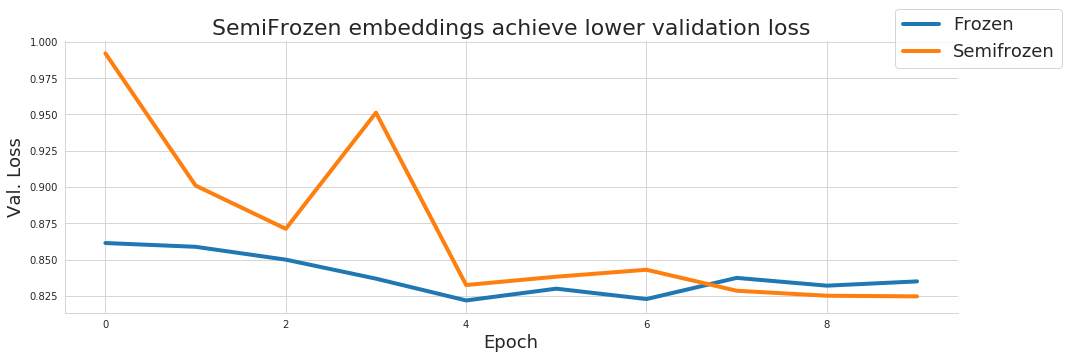

In [37]:
fig, ax = plt.subplots(1,1, figsize=(16,5), sharex=True)
sns.despine(fig)
ax.plot(frozen_learn.recorder.val_losses,label='Frozen', lw=4)
ax.plot(semifrozen_learn.recorder.val_losses,label='Semifrozen', lw=4)
ax.set_xlabel("Epoch", size=18)
ax.set_ylabel("Val. Loss", size=18)
ax.set_title("SemiFrozen embeddings achieve lower validation loss", size=22)
fig.legend(fontsize=18)

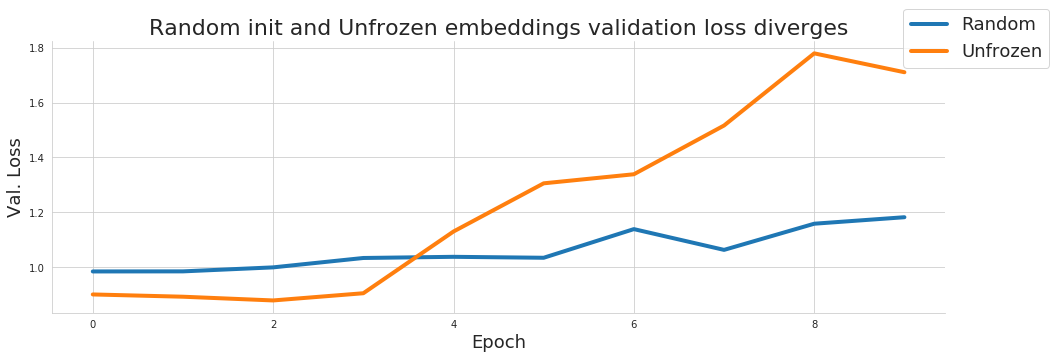

In [38]:
fig, ax = plt.subplots(1,1, figsize=(16,5), sharex=True)
sns.despine(fig)
ax.plot(random_learn.recorder.val_losses,label='Random', lw=4)
ax.plot(unfrozen_learn.recorder.val_losses,label='Unfrozen', lw=4)
ax.set_xlabel("Epoch", size=18)
ax.set_ylabel("Val. Loss", size=18)

ax.set_title('Random init and Unfrozen embeddings validation loss diverges', size=22)
fig.legend(fontsize=18)

# Predict

In [ ]:
import fastprogress

In [ ]:
import re
predict_path = pathlib.Path('/home/martin/data/fakenews/dev-INPUT/tasks-2-3/dev/')
res = []
files = list(predict_path.glob('*.txt'))
for fn in fastprogress.progress_bar(files):
    text = fn.read_text()
    line_it = text.split('\n')
    article_id = fn.name.replace('article', '').replace('.txt','')
    fn_labels = pathlib.Path(fn.as_posix().replace('.txt', '.task2.labels'))
    labels_text = fn_labels.read_text()
    labels_it = labels_text.split('\n')
    for i, (line, l) in enumerate(zip(line_it,labels_it)):
        if l == "":
            continue
        label = semifrozen_learn.predict(line)
        score = torch.sigmoid(label[2])
        if torch.sigmoid(label[2]) > 0.4:
            label = 'propaganda'
        else:
            label = 'non-propaganda'
        res.append({'text': line, 'article_id': article_id, 'line': i+1, 'label':label, 'score': score})

In [ ]:
res = pd.DataFrame(res)

In [ ]:
pd.DataFrame(res)[["article_id", "line", "label"]].to_csv('/tmp/res.tsv',sep='\t', header=None, index=False)

In [ ]:
!subl /tmp/res.tsv

In [104]:
len(data)

15170